
# TODO

1. implement data split with DateSplitter
2. implement stricter validation, which will maybe produce overfitting :)
3. implement early stopping callback
4. use mqcnn model?















































# How to do Validation/ Early stopping for Time Series forecasting

This notebook illustrates how one can implement a time series model using PyTorch, and use it together with the rest of the GluonTS ecosystem for data loading, feature processing, and model evaluation.

In [1]:
from typing import List, Optional, Callable
from itertools import islice

In [2]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.dates as mdates

In [3]:
from gluonts.dataset.field_names import FieldName
from gluonts.dataset.loader import TrainDataLoader, ValidationDataLoader, InferenceDataLoader
from gluonts.dataset.repository.datasets import get_dataset
from gluonts.evaluation import Evaluator
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.torch.batchify import batchify 
from gluonts.torch.support.util import copy_parameters
from gluonts.torch.model.predictor import PyTorchPredictor
from gluonts.transform import Chain, AddObservedValuesIndicator, InstanceSplitter, ExpectedNumInstanceSampler

For this example we will use the "electricity" dataset, which can be loaded as follows.

In [4]:
dataset = get_dataset("m4_hourly")

In [5]:
# For this notebook, lets take only a subset of the time series 
dataset_train = list(islice(dataset.train, 15))
dataset_test  = list(islice(dataset.test, 15))

In [6]:
prediction_length = dataset.metadata.prediction_length
context_length = prediction_length

### Part 1: "Global model, local validation"
Validation Technique should fit your application!

In [7]:
train_entry = next(iter(dataset.train))
test_entry = next(iter(dataset.test))
train_end = train_entry["start"] + pd.Timedelta(value=len(train_entry["target"]), unit="h")
test_end = test_entry["start"] + pd.Timedelta(value=len(test_entry["target"]), unit="h")
start = train_entry["start"]

def plot_dataset(data, is_test, n_series, test_end, train_end=None, validation_date=None, batch=None):    
    date_formater = mdates.DateFormatter('%b, %d')
    fig = plt.figure(figsize=(12,8))
    
    for idx, entry in enumerate(islice(data, n_series)):
        ax = plt.subplot(n_series, 1, idx+1)
        
        # plot train data
        t = pd.date_range(start=entry["start"], end=train_end-pd.Timedelta(value=1, unit="h"), freq=entry["start"].freq)
        plt.plot(t, entry["target"][:len(t)], label = "train")
        
        plt.xlim(entry["start"], test_end)
        
        # plot test data and color the validation data
        if is_test:
            t_test = pd.date_range(start=train_end, end=test_end-pd.Timedelta(value=1, unit="h"), freq=entry["start"].freq)
            plt.plot(t_test, entry["target"][-len(t_test):], color="red", label="test")
            
            if validation_date:
                t_eval = pd.date_range(start=validation_date, end=train_end, freq=entry["start"].freq)
                plt.plot(t_eval, entry["target"][-(len(t_eval)+len(t_test)):-len(t_test)], color="m", label="eval")
        
        # plot batch instances as areas
        if batch:
            for forecast_start, past_target, future_target, instance_id in zip(batch['forecast_start'],
                                                                         batch['past_target'],
                                                                         batch['future_target'], batch['item_id']):
                if(instance_id==idx):
                    t_past = pd.date_range(start=forecast_start-pd.Timedelta(value=prediction_length, unit="h"), end=forecast_start-pd.Timedelta(value=1, unit="h"), freq=start.freq)
                    
                    ax.axvspan(forecast_start-pd.Timedelta(value=prediction_length, unit="h"), forecast_start-pd.Timedelta(value=1, unit="h"), alpha=0.5, color='lightsteelblue')

                    ax.axvspan(forecast_start, forecast_start+pd.Timedelta(value=prediction_length-1, unit="h"), alpha=0.5, color='lightcoral')




        if(idx<n_series-1):
            plt.tick_params(axis='x', which='both', bottom=False, labelbottom=False)
    plt.xticks(pd.date_range(start=entry["start"], periods=4, freq="10d"))
    ax.xaxis.set_major_formatter(date_formater)
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='right')

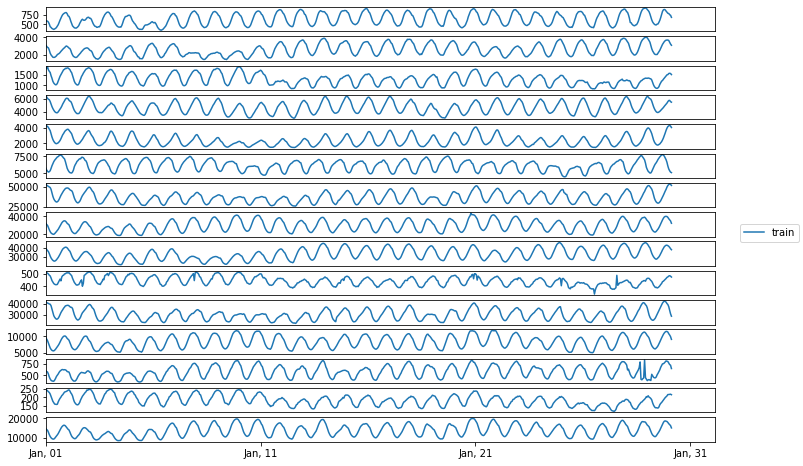

In [8]:
plot_dataset(dataset_train, is_test=False, n_series=15, train_end=train_end, test_end=test_end)

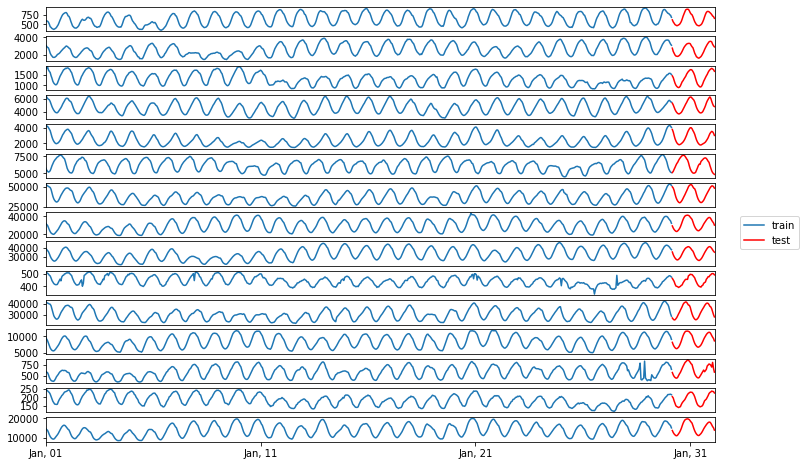

In [9]:
plot_dataset(dataset_test, is_test=True, n_series=15, test_end=test_end, train_end=train_end)

### a reasonable way of doing validation for this prediction task

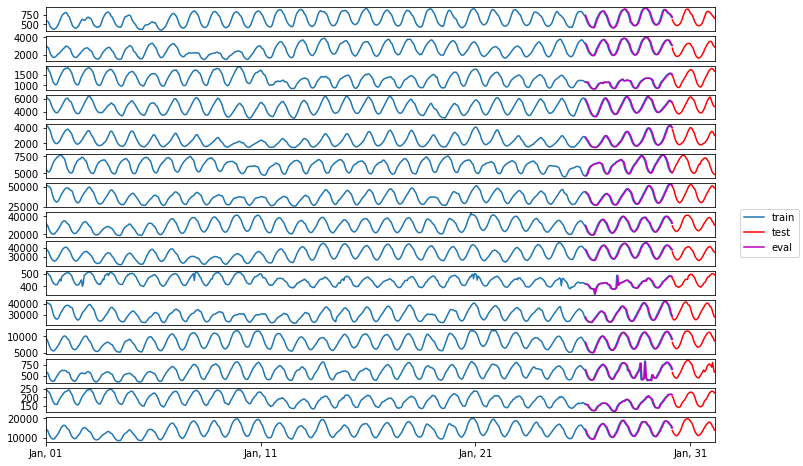

In [10]:
validation_date = train_end - pd.Timedelta(2*prediction_length+1, unit="h")
plot_dataset(dataset.test, is_test=True, n_series=15, test_end=test_end, train_end=train_end, validation_date=validation_date)

In [11]:
### Defining the dataloader 

In [12]:
# only transformation we employ here is the instance splitter. splits timeseries to get training instances
transformation = InstanceSplitter(
                    target_field=FieldName.TARGET,
                    is_pad_field=FieldName.IS_PAD,
                    start_field=FieldName.START,
                    forecast_start_field=FieldName.FORECAST_START,
                    train_sampler=ExpectedNumInstanceSampler(num_instances = 1.),
                    past_length=context_length,
                    future_length=prediction_length,
                    pick_incomplete=False
                    
                )

In [13]:
# split of validation dataset from train dataset


# todo use: class TrainTestSplit(pydantic.BaseModel):


n_trainpoints = len(pd.date_range(start, validation_date, freq="h")) 

dataset_validation = []
for entry in dataset_train:
    
    validation_time_series = entry.copy()
    validation_time_series.update({"start": validation_date-pd.Timedelta(value=context_length, unit="h"), "target": entry["target"][(n_trainpoints-context_length):]})
    dataset_validation.append(validation_time_series)
    
    entry["target"] = entry["target"][:n_trainpoints]




In [14]:
from gluonts.dataset.common import ListDataset
dataset_train = ListDataset(dataset_train, freq="h")
dataset_validation = ListDataset(dataset_validation, freq="h")

In [15]:
from gluonts.torch.batchify import batchify
from functools import partial
num_batches_per_epoch = 16
training_data_loader = TrainDataLoader(
            dataset=dataset_train,
            transform=transformation,
            batch_size=16,
            num_batches_per_epoch=num_batches_per_epoch,
            stack_fn=partial(batchify, device=torch.device("cpu")))

In [16]:
batch = next(iter(training_data_loader))
len(batch["start"])

16

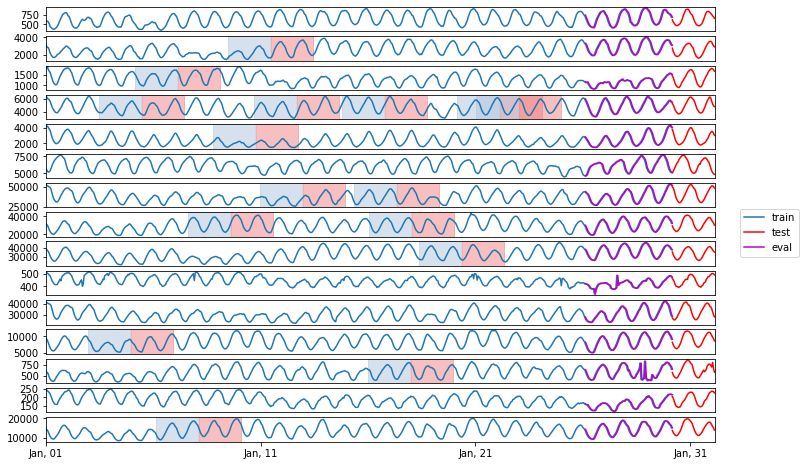

In [17]:
plot_dataset(dataset.test, is_test=True, n_series=15, test_end=test_end, train_end=train_end, validation_date=validation_date, batch=batch)

In [38]:
validation_data_loader = TrainDataLoader(
            dataset=dataset_validation,
            transform=transformation,
            batch_size = 15,
    num_batches_per_epoch=1,
            stack_fn=partial(batchify, device=torch.device("cpu")))

In [39]:
batch = next(iter(validation_data_loader))


In [40]:
len(batch["start"])

15

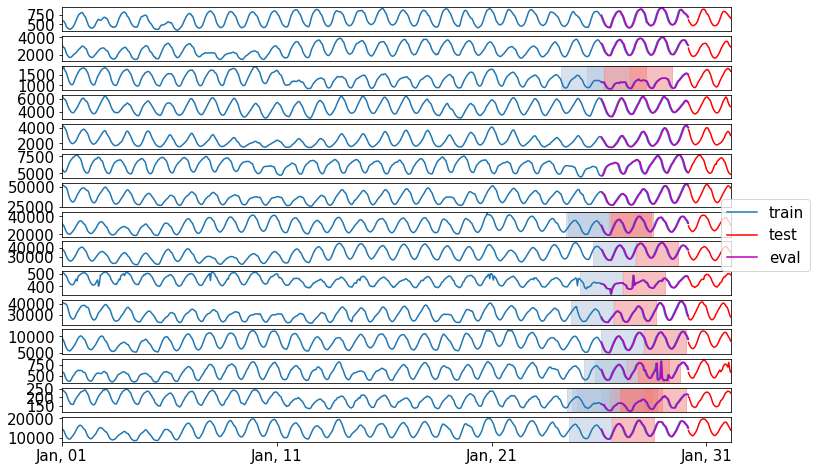

In [41]:
plot_dataset(dataset.test, is_test=True, n_series=15, test_end=test_end, train_end=train_end, validation_date=validation_date, batch=batch)

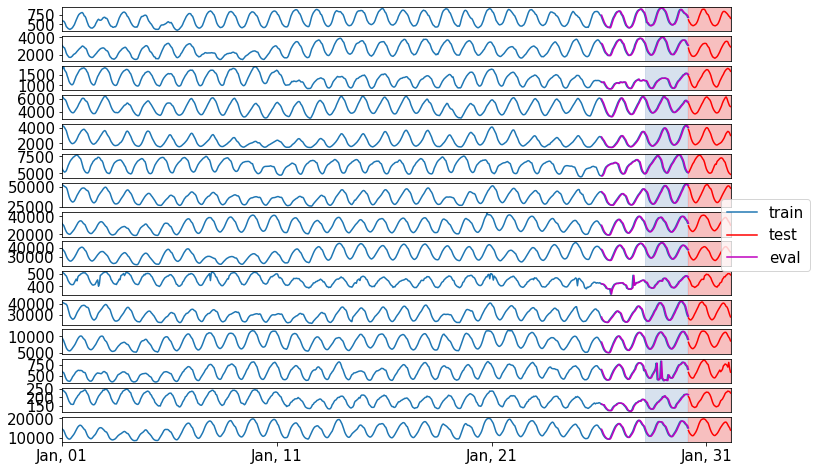

In [37]:
test_data_loader = InferenceDataLoader(
            dataset=dataset_validation,
            transform=transformation,
            batch_size = 15,
            stack_fn=partial(batchify, device=torch.device("cpu")))
batch = next(iter(test_data_loader))

plot_dataset(dataset.test, is_test=True, n_series=15, test_end=test_end, train_end=train_end, validation_date=validation_date, batch=batch)

## Probabilistic feed-forward network using PyTorch

We will use a pretty simple model, based on a feed-forward network whose output layer produces the parameters of a Student's t-distribution at each time step in the prediction range. We will define two networks based on this idea:
* The `TrainingFeedForwardNetwork` computes the loss associated with given observations, i.e. the negative log-likelihood of the observations according to the output distribution; this will be used during training.
* The `SamplingFeedForwardNetwork` will be used at inference time: this uses the output distribution to draw a sample of a given size, as a way to encode the predicted distribution.

In [22]:
def mean_abs_scaling(context, min_scale=1e-5):
    return context.abs().mean(1).clamp(min_scale, None).unsqueeze(1)

In [23]:
def no_scaling(context):
    return torch.ones(context.shape[0], 1)

In [24]:
class TrainingFeedForwardNetwork(nn.Module):
    distr_type = torch.distributions.StudentT
    
    def __init__(
        self,
        prediction_length: int,
        context_length: int,
        hidden_dimensions: List[int],
        batch_norm: bool=False,
        scaling: Callable=mean_abs_scaling,
    ) -> None:
        super().__init__()
        
        assert prediction_length > 0
        assert context_length > 0
        assert len(hidden_dimensions) > 0
        
        self.prediction_length = prediction_length
        self.context_length = context_length
        self.hidden_dimensions = hidden_dimensions
        self.batch_norm = batch_norm
        self.scaling = scaling
        
        dimensions = [context_length] + hidden_dimensions[:-1]

        modules = []
        for in_size, out_size in zip(dimensions[:-1], dimensions[1:]):
            modules += [self.__make_lin(in_size, out_size), nn.ReLU()]
            if batch_norm:
                modules.append(nn.BatchNorm1d(units))
        modules.append(self.__make_lin(dimensions[-1], prediction_length * hidden_dimensions[-1]))
        self.nn = nn.Sequential(*modules)
        
        self.df_proj = nn.Sequential(self.__make_lin(hidden_dimensions[-1], 1), nn.Softplus())
        self.loc_proj = self.__make_lin(hidden_dimensions[-1], 1)
        self.scale_proj = nn.Sequential(self.__make_lin(hidden_dimensions[-1], 1), nn.Softplus())
    
    @staticmethod
    def __make_lin(dim_in, dim_out):
        lin = nn.Linear(dim_in, dim_out)
        torch.nn.init.uniform_(lin.weight, -0.07, 0.07)
        torch.nn.init.zeros_(lin.bias)
        return lin
    
    def distr_and_scale(self, context):
        scale = self.scaling(context)
        scaled_context = context / scale
        nn_out = self.nn(scaled_context)
        nn_out_reshaped = nn_out.reshape(-1, self.prediction_length, self.hidden_dimensions[-1])
        
        distr_args = (
            2.0 + self.df_proj(nn_out_reshaped).squeeze(dim=-1),
            self.loc_proj(nn_out_reshaped).squeeze(dim=-1),
            self.scale_proj(nn_out_reshaped).squeeze(dim=-1),
        )
        distr = net.distr_type(*distr_args)
        
        return distr, scale
    
    def forward(self, context, target):
        assert context.shape[-1] == self.context_length
        assert target.shape[-1] == self.prediction_length
        
        distr, scale = self.distr_and_scale(context)
        loss = (-distr.log_prob(target / scale) + torch.log(scale)).mean(dim=1)
        
        return loss

In [25]:
class SamplingFeedForwardNetwork(TrainingFeedForwardNetwork):
    def __init__(self, *args, num_samples: int = 1000, **kwargs):
        super().__init__(*args, **kwargs)
        self.num_samples = num_samples
        
    def forward(self, context):
        assert context.shape[-1] == self.context_length
        
        distr, scale = self.distr_and_scale(context)
        sample = distr.sample((self.num_samples, )) * scale
        
        return sample.permute(1, 0, 2)

In [26]:
net = TrainingFeedForwardNetwork(
    prediction_length=prediction_length,
    context_length=context_length,
    hidden_dimensions=[128, 64, 64],
    batch_norm=False,
    scaling=mean_abs_scaling,
)

## Train and evaluate the model

In [27]:
optimizer = torch.optim.SGD(net.parameters(), lr = 0.01)
train_history = {"train_loss": [], "validation_loss": []}

for epoch_no in range(350):
    sum_epoch_loss = 0.0
    for batch_no, batch in enumerate(training_data_loader, start=1):
        optimizer.zero_grad()

        context = batch["past_target"]
        target = batch["future_target"]
        loss_vec = net(context, target)
        loss = loss_vec.mean()
        loss.backward()
        
        optimizer.step()
        
        sum_epoch_loss += loss.detach().numpy().item()
        
    train_loss = sum_epoch_loss / num_batches_per_epoch
    # validation
    validation_batch = next(iter(validation_data_loader))
    
    context = batch["past_target"]
    target = batch["future_target"]
    
    val_loss_vec = net(context, target)
    
    val_loss = val_loss_vec.mean().detach().numpy().item()
    
    train_history["train_loss"].append(train_loss)
    train_history["validation_loss"].append(val_loss)

    print(f"{epoch_no}: Train loss: {round(train_loss,4)}, Validation loss: {round(val_loss,4)}")

0: Train loss: 9.7794, Validation loss: 10.3662
1: Train loss: 9.3848, Validation loss: 8.3915
2: Train loss: 9.4197, Validation loss: 10.5908
3: Train loss: 9.0819, Validation loss: 8.9543
4: Train loss: 8.9831, Validation loss: 8.4815
5: Train loss: 8.8987, Validation loss: 8.2223
6: Train loss: 8.6805, Validation loss: 7.3414
7: Train loss: 8.7407, Validation loss: 8.6553
8: Train loss: 8.6932, Validation loss: 9.2459
9: Train loss: 8.6694, Validation loss: 8.5504
10: Train loss: 8.7044, Validation loss: 10.0979
11: Train loss: 8.296, Validation loss: 7.6699
12: Train loss: 8.3002, Validation loss: 7.7144
13: Train loss: 8.4398, Validation loss: 7.4292
14: Train loss: 8.3385, Validation loss: 8.142
15: Train loss: 8.3481, Validation loss: 8.9209
16: Train loss: 8.1298, Validation loss: 8.4841
17: Train loss: 8.3162, Validation loss: 8.9451
18: Train loss: 8.2277, Validation loss: 8.8881
19: Train loss: 8.0215, Validation loss: 8.5746
20: Train loss: 8.2227, Validation loss: 7.5471
2

172: Train loss: 7.4006, Validation loss: 6.4526
173: Train loss: 7.4269, Validation loss: 8.2302
174: Train loss: 7.5439, Validation loss: 7.7205
175: Train loss: 7.4807, Validation loss: 8.052
176: Train loss: 7.3702, Validation loss: 6.7859
177: Train loss: 7.4756, Validation loss: 7.9018
178: Train loss: 7.6204, Validation loss: 8.2819
179: Train loss: 7.4098, Validation loss: 7.3873
180: Train loss: 7.2133, Validation loss: 6.7643
181: Train loss: 7.1724, Validation loss: 5.7599
182: Train loss: 7.6228, Validation loss: 8.3499
183: Train loss: 7.1239, Validation loss: 7.1354
184: Train loss: 7.5497, Validation loss: 6.804
185: Train loss: 7.5467, Validation loss: 8.7881
186: Train loss: 7.3621, Validation loss: 7.1934
187: Train loss: 7.4447, Validation loss: 7.3148
188: Train loss: 7.3477, Validation loss: 7.1846
189: Train loss: 7.2245, Validation loss: 6.2374
190: Train loss: 7.4247, Validation loss: 6.3416
191: Train loss: 7.4474, Validation loss: 5.8655
192: Train loss: 7.438

344: Train loss: 7.2953, Validation loss: 6.5488
345: Train loss: 7.4273, Validation loss: 6.4833
346: Train loss: 7.4888, Validation loss: 8.0585
347: Train loss: 7.3677, Validation loss: 6.7107
348: Train loss: 7.4083, Validation loss: 7.6212
349: Train loss: 7.4126, Validation loss: 6.6189


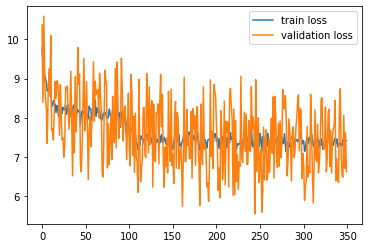

In [28]:
for label in ["train_loss", "validation_loss"]:
    plt.plot(train_history[label], label=label.replace("_", " "))
plt.legend()

## Create predictor out of the trained model, and test it

We now have a trained model, whose parameters can be copied over to a `SamplingFeedForwardNetwork` object: we will wrap this into a `PyTorchPredictor` that can be used for inference tasks.

In [29]:
pred_net = SamplingFeedForwardNetwork(
    prediction_length=net.prediction_length,
    context_length=net.context_length,
    hidden_dimensions=net.hidden_dimensions,
    batch_norm=net.batch_norm,
)
copy_parameters(net, pred_net)

predictor_pytorch = PyTorchPredictor(
    prediction_length=prediction_length, freq = dataset.metadata.freq, 
    input_names = ["past_target"], prediction_net=pred_net, batch_size=32, input_transform=transformation,
    device=None
)

For example, we can do backtesting on the test dataset: in what follows, `make_evaluation_predictions` will slice out the trailing `prediction_length` observations from the test time series, and use the given predictor to obtain forecasts for the same time range.

In [30]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=dataset.test,
    predictor=predictor_pytorch,
    num_samples=1000,
)

forecasts_pytorch = list(forecast_it)
tss_pytorch = list(ts_it)

Once we have the forecasts, we can plot them:

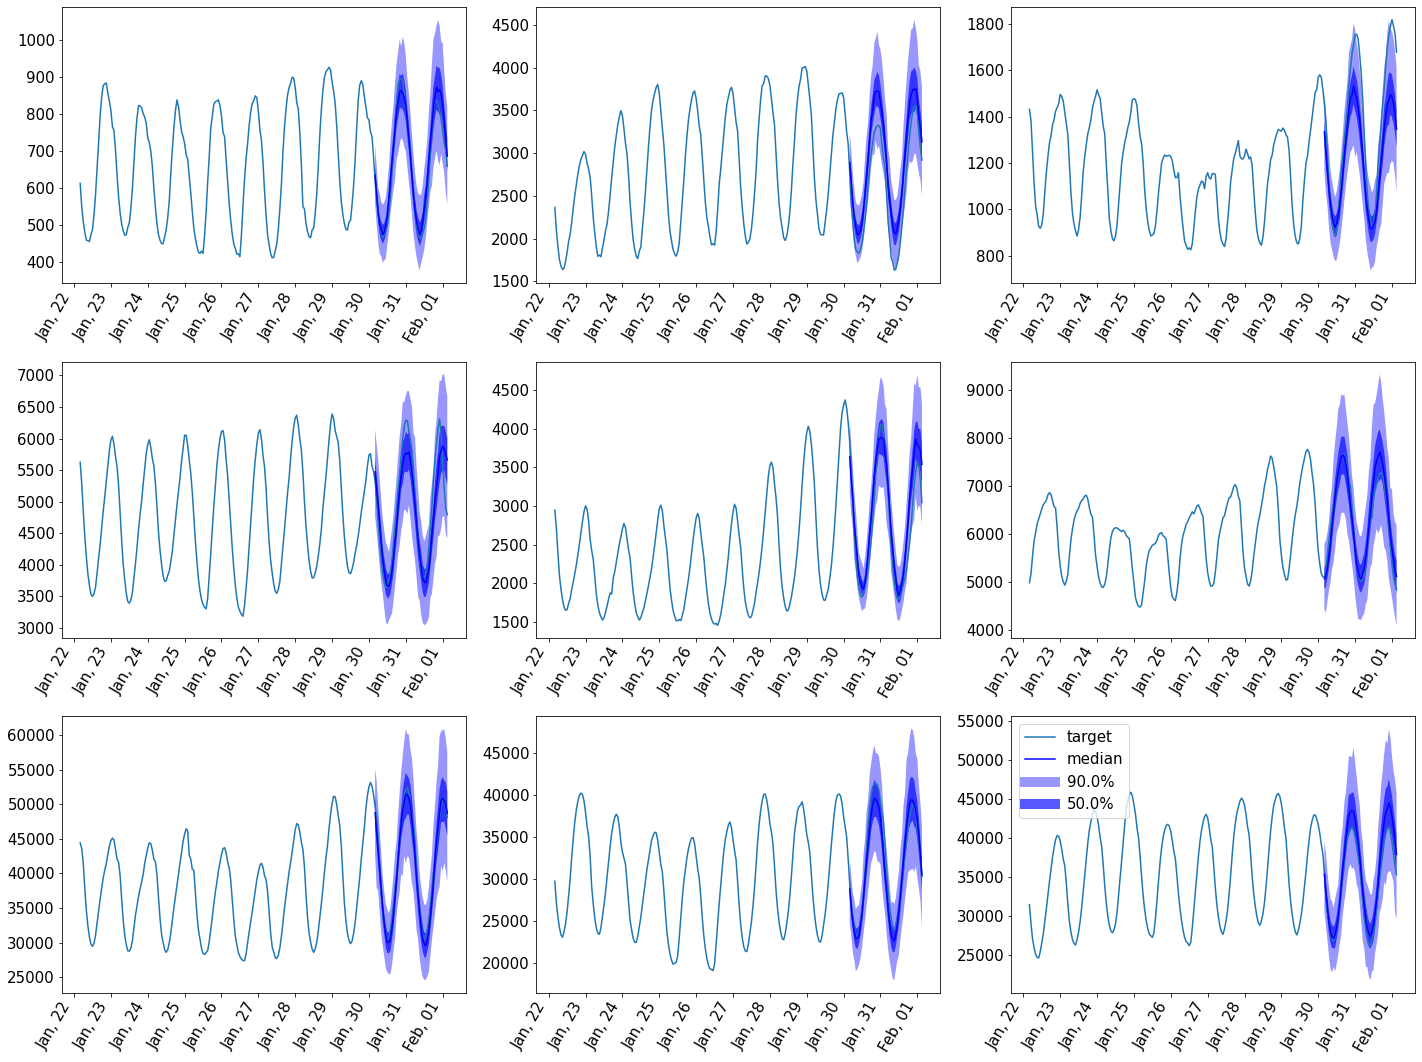

In [31]:
plt.figure(figsize=(20, 15))
date_formater = mdates.DateFormatter('%b, %d')
plt.rcParams.update({'font.size': 15})

for idx, (forecast, ts) in islice(enumerate(zip(forecasts_pytorch, tss_pytorch)), 9):
    ax =plt.subplot(3, 3, idx+1)
    
    plt.plot(ts[-5 * prediction_length:], label="target")
    forecast.plot()
    plt.xticks(rotation=60)
    ax.xaxis.set_major_formatter(date_formater)
    
plt.gcf().tight_layout()
plt.legend()
plt.show()

And we can compute evaluation metrics, that summarize the performance of the model on our test data.

In [32]:
evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])

In [33]:
metrics_pytorch, _ = evaluator(iter(tss_pytorch), iter(forecasts_pytorch), num_series=len(dataset.test))
pd.DataFrame.from_records(metrics_pytorch, index=["FeedForward"]).transpose()

Running evaluation: 100%|██████████| 414/414 [00:00<00:00, 6823.01it/s]


,FeedForward
Coverage[0.1],1.783917e-01
Coverage[0.5],4.270833e-01
Coverage[0.9],8.568337e-01
MAE_Coverage,6.482488e-02
MAPE,3.832904e-01
MASE,2.991525e+00
MSE,2.867966e+06
MSIS,4.399581e+01
ND,4.631813e-02
NRMSE,2.312011e-01


### Global validation